#### Reanalysis idea
----
Watson - recorded from PFC as rats slept

OG goal: During high theta states, do we observe coordinated neuronal activity patterns at theta?

Actual goal: Can I identify high theta power states in the cortex?

----
Processing variable contains awake and sleep data

#### Define dandiset

In [16]:
# dandiset ID
dandiset_id = '000041'

# libraries
import pynwb
import requests
from nwbwidgets import nwb2widget
from pynwb import NWBHDF5IO
import pandas
import numpy as np

#### Prep stuff

In [17]:
def _search_assets(url, filepath):
    response = requests.request("GET", url, headers={"Accept": "application/json"}).json() 
    
    for asset in response["results"]:
        if filepath == asset["path"]:
            return asset["asset_id"]
    
    if response.get("next", None):
        return _search_assets(response["next"], filepath)
    
    raise ValueError(f'path {filepath} not found in dandiset {dandiset_id}.')

def get_asset_id(dandiset_id, filepath):
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/"
    return _search_assets(url, filepath)

def get_s3_url(dandiset_id, filepath):
    """Get the s3 location for any NWB file on DANDI"""

    asset_id = get_asset_id(dandiset_id, filepath)
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/{asset_id}/download/"
    
    s3_url = requests.request(url=url, method='head').url
    if '?' in s3_url:
        return s3_url[:s3_url.index('?')]
    return s3_url

In [18]:
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
import os # import os

# lets get all sessions for each rat
with DandiAPIClient() as client:
    
    # get dandiset using the ID code
    dandiset = client.get_dandiset(dandiset_id,'draft')
    
    # list splits the "zipped" generator file
    assets   = list(dandiset.get_assets())
    
    # list comprehension
    rats = {os.path.split(x.path)[0] for x in assets} # list comprehension, for loop, {} if unique

    # actually just work with sessions for now and call it a day
    sessions = [x.path for x in assets]
    #print(sessions)

    #asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    #s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

#### Get one session for now

In [20]:
# using the rats variables, organize your data
rats

{'sub-BWRat17',
 'sub-BWRat18',
 'sub-BWRat19',
 'sub-BWRat20',
 'sub-BWRat21',
 'sub-Bogey',
 'sub-Dino',
 'sub-Rizzo',
 'sub-Splinter',
 'sub-Templeton'}

In [21]:
sessions 

['sub-BWRat17/sub-BWRat17_ses-BWRat17-121912_ecephys.nwb',
 'sub-BWRat17/sub-BWRat17_ses-BWRat17-121712_ecephys.nwb',
 'sub-BWRat18/sub-BWRat18_ses-BWRat18-020513_ecephys.nwb',
 'sub-BWRat19/sub-BWRat19_ses-BWRat19-032413_ecephys.nwb',
 'sub-BWRat19/sub-BWRat19_ses-BWRat19-032513_ecephys.nwb',
 'sub-BWRat20/sub-BWRat20_ses-BWRat20-101013_ecephys.nwb',
 'sub-BWRat20/sub-BWRat20_ses-BWRat20-101513_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121613_ecephys.nwb',
 'sub-Bogey/sub-Bogey_ses-Bogey-012615_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121813_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121113_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-061814_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072314_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072114_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-061914_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072414_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-062014_ecephys.nwb',
 'sub-Rizzo/sub-Rizzo_ses-Rizzo-022715_ecephys.nwb',
 'su

In [6]:
#nwb

NameError: name 'nwb' is not defined

In [22]:
# select 1 session for now to get code working
tempAssetID = sessions[0]
asset_id = get_asset_id(dandiset_id, tempAssetID) # this is the URL for download
s3_path  = get_s3_url(dandiset_id, tempAssetID) # this is the path to streaming
#print(asset_id)

# use the "Read Only S3" (ros3) driver to stream data directly from DANDI (or any other S3 location)
io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')

# read nwb file according to the s3 bucket path
nwb = io.read()

#Get the fields within the NWB file
nwbFields = nwb.fields
#print(nwbFields)

#from nwbwidgets import nwb2widget
#nwb2widget(nwb)

# read out the nwb file as it is a dict
nwbFile = nwb.electrodes['location'].data[:]
#nwbFile = nwb.intervals['epochs']
regions = list(nwbFile)

#nwb.trials.to_dataframe()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [23]:
nwb

root pynwb.file.NWBFile at 0x140289974826224
Fields:
  devices: {
    implant <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    shank1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank3 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank4 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank5 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank6 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank7 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank8 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank9 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Brendon Watson']
  file_create_date: [datetime.datetime(2020, 10, 3, 13, 49, 41, 955624, tzinfo=tzoffset(None, -14400))]
  identifier: BWRat17_121912
  institution: NYU
  lab: Buzsaki
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ecephys <class 'pynwb.base.ProcessingModule'>
  }
  related_publ

In [24]:
nwb2widget(nwb)

In [25]:
# get behavioral data into dataframe
df_behavior = nwb.processing['behavior']['states'].to_dataframe()
df_behavior.shape

(71, 3)

Note that what you see below is simplified.

You could also do the following (which closely resembles dict organization):

`nwb.processing['ecephys'].data_interfaces['LFP'].electrical_series['lfp']`

In [26]:
# get lfp data out from just 1 shank
lfpData_s1 = nwb.processing['ecephys']['LFP']['lfp'].data[:,0:8]

In [10]:
lfpData_s1.shape

(27354000, 8)

In [11]:
# get the sampling rate of LFP - make sure this is an int-type (rounded, whole number) for indexing
srate_lfp = nwb.processing['ecephys']['LFP']['lfp'].rate.astype(int)
type(srate_lfp)

numpy.int64

In [12]:
exData = lfpData_s1[0:1250-1,0]

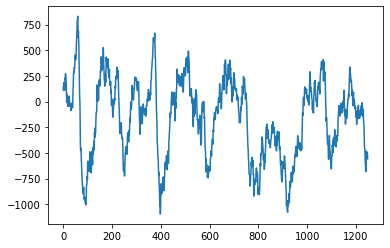

In [13]:
# plot example trace
import matplotlib.pyplot as plt
plt.plot(exData)

In [154]:
# calculate coherence over moving window
amountData = srate_lfp*120 # 120 seconds
slData = lfpData_s1[0:amountData-1,1]
slData

array([ 129,  157,  234, ..., -177, -232, -229], dtype=int16)

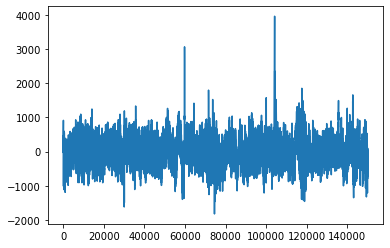

In [155]:
# notice that this plot has some noise peaks, I'm ignoring them for now
plt.plot(slData)

In [18]:
from obspy.signal.detrend import polynomial
from scipy.signal import welch

In [156]:
# run power spectrum using 1.25s increments over .25s steps
amountTime = (srate_lfp*1.5).astype(int)
tempData = slData[0:amountTime-1]

# detrend data by fitting and removing a 3rd degree polynomial
dataDet  = polynomial(tempData,3)

# power spectrum
f,Ptemp = welch(tempData,srate_lfp.astype(float),nperseg=1000)

# restrict data to 1-50hz for plot proofing
#f[f>1]
idxspec = np.where((f>1) & (f<100))
fSpec = f[idxspec]
PSpec = Ptemp[idxspec]

# log10 transform
PSpecLog = np.log10(PSpec)

Text(0.5, 1.0, '6-9hz theta oscillation')

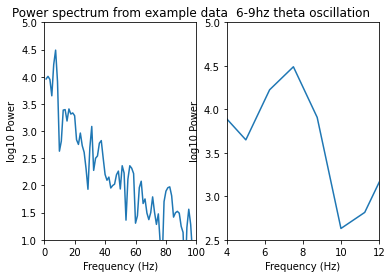

In [157]:
#plt.plot(dataDet)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(fSpec,PSpecLog)
ax1.set_xlim([0, 100])
ax1.set_ylim([1,5])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('log10 Power')
ax1.set_title('Power spectrum from example data')

ax2.plot(fSpec,PSpecLog)
ax2.set_xlim([4,12])
ax2.set_ylim([2.5,5])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('log10 Power')
ax2.set_title('6-9hz theta oscillation')

In [107]:
# define spectral coherence
#from scipy.signal import hilbert

# filter for theta

# hilbert transform
#hilbData = hilbert(slData)
# instantaneous power = inst ampl^2
#instPower = pow(np.abs(hilbData),2)
#print(instPower)
#instPower.shape

[363864.28362853 149786.58536546 200503.43479989 ... 111690.77608238
 166726.52845051 406736.86197149]


----
#### Moving window power spectral estimations

----

In [158]:
windowSize = (srate_lfp*1.5).astype(int)
windowStep = (srate_lfp*0.2).astype(int)
totalDataSize = len(slData)
#print(windowStep)

# make a looper variable from 0, every 200ms, to end of data
looperVar = np.arange(0,totalDataSize,windowStep-1)
#looperVar

----
#### Get the mean and std of the distribution to define movement artifacts
----

In [159]:
# get mean and std of entire distribution of dataset
from scipy.stats import zscore
zSlData = zscore(slData)

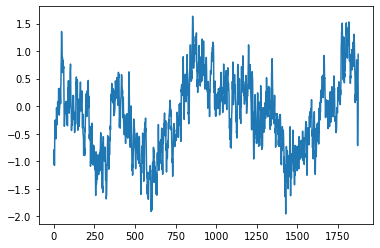

In [161]:
stepi = 10
#print([looperVar[stepi]:looperVar[stepi+1]])
temp = zSlData[looperVar[stepi]:looperVar[stepi]+windowSize]
plt.plot(temp)

In [162]:
(looperVar[0]+windowSize)-1

1874

In [163]:
range(len(looperVar))

range(0, 603)

In [411]:
powTheta = []
powDelta = []
powThetaAll = []
arrayAll = []
arrayTheta = []
for i in range(len(looperVar)):
    
    # get temp data
    tempData = slData[looperVar[i]:(looperVar[i]+windowSize)-1]

    if len(tempData) != ((looperVar[0]+windowSize)-1):
        continue
        
    # detrend data by fitting and removing a 3rd degree polynomial
    dataDet  = polynomial(tempData,3)  

    # power spectrum
    f,Ptemp = welch(tempData,srate_lfp.astype(float),nperseg=1000)

    # restrict data to 1-50hz for plot proofing
    #f[f>1]
    idxspec = np.where((f>0) & (f<100))
    fSpec = f[idxspec]
    #print(f)
    PSpec = Ptemp[idxspec]

    # log10 transform
    PSpecLog = np.log10(PSpec) 
    #plt.plot(fSpec,PSpecLog)

    # now get theta out
    idxTheta = np.where((fSpec > 6) & (fSpec < 9))
    #print(f[idxTheta])
    Ptheta  = np.mean(PSpecLog[idxTheta])
    
    # get delta power
    idxDelta = np.where((fSpec > 1) & (fSpec < 4))
    Pdelta = np.mean(PSpecLog[idxDelta])
    
    # store data if theta > delta - actually this isn't the best way.
    # we should instead fit a line that assumes a 1/f distribution matching the 
    # power spectrum, then find instances when theta power is above 1std from the mean
    if Ptheta > Pdelta:
        powTheta.append(Ptheta)
        arrayTheta.append(PSpecLog)
    if Pdelta > Ptheta:
        powDelta.append(Pdelta)
    
    powThetaAll.append(powThetaAll)
    
    # hstack the array into a list
    arrayAll.append(np.hstack(PSpecLog))

# this array contains vertically concatenated
arrayAll   = np.vstack(array)
arrayTheta = np.vstack(arrayTheta)
    

Text(0, 0.5, 'log10 prefrontal 6-9hz power')

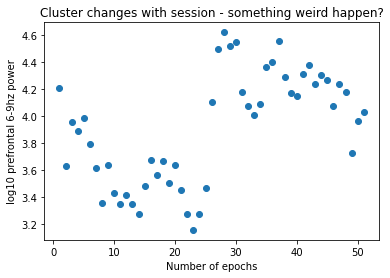

In [412]:
numEvents = np.linspace(1,len(powTheta),len(powTheta))
plt.scatter(numEvents,powTheta)
plt.title('Cluster changes with session - something weird happen?')
plt.xlabel('Number of epochs')
plt.ylabel('log10 prefrontal 6-9hz power')

Lets do some kmeans clustering, then go back to the power spectra.

In [477]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=1)

# convert to matrix
data4k = []
data4k.append(np.hstack(np.array(numEvents)))
data4k.append(np.hstack(np.array(powTheta)))
data4k = np.vstack(data4k)
type(data4k)
data4k = np.transpose(data4k)

# use unsupervised approach
from sklearn.cluster import KMeans

# kmeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(data4k)

# indexed events through kmeans
idxKMeans = kmeans.predict(data4k)
#print(idxKMeans)
#print(np.where(idxKMeans==0))

# get the split data
idxSplit1 = np.where(idxKMeans==1)
idxSplit0 = np.where(idxKMeans==0)

# plot the data
thetaPow1 = arrayTheta[idxSplit1,]
thetaPow0 = arrayTheta[idxSplit0,]


In [478]:
# reshape
shape0 = thetaPow0.shape
shape0 = shape0[1:]
shape1 = thetaPow1.shape
shape1 = shape1[1:]

In [480]:
type(shape0)

tuple

In [481]:
# reshape
thetaPow0 = np.reshape(thetaPow0,[shape0[0], shape0[1]])
thetaPow1 = np.reshape(thetaPow1,[shape1[0], shape1[1]])

In [486]:
# avg and error?
avgPow1 = np.mean(thetaPow1,axis=0)
avgPow0 = np.mean(thetaPow0,axis=0)

(1.0, 5.0)

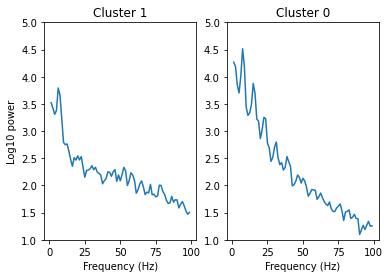

In [497]:
# get average power

# prep
fig, (ax1, ax2) = plt.subplots(1, 2)

# idx 1
ax1.plot(fSpec,avgPow1)
ax1.set_ylabel('Log10 power')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_title('Cluster 1')
ax1.set_ylim([1.0,5.0])

# idx 0
ax2.plot(fSpec,avgPow0)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_title('Cluster 0')
ax2.set_ylim([1.0,5.0])

----
*Something weird happened towards the end of the session. But this is good to know.
I need to normalize or standardize the power spectrum*
----

In [522]:
# what sort of behavioral changes occurred?
nwb2widget(nwb)
# estimate timeseries
#TimeSeries = 


#### Another approach to identifying theta events in PFC

Text(0.5, 0, 'Frequency (Hz)')

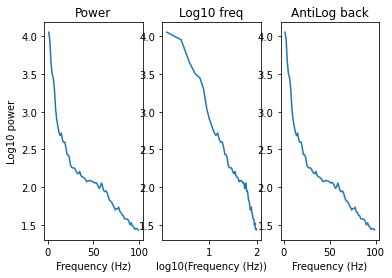

In [498]:
# get average across epochs
avgPowDist = np.mean(array,axis=0)

# prep
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# plot log10 pow
ax1.plot(fSpec,avgPowDist)
ax1.set_ylabel('Log10 power')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_title('Power')

# log10 freq x log10 pow
log10Freq = np.log10(fSpec)
ax2.plot(log10Freq,avgPowDist)
ax2.set_xlabel('log10(Frequency (Hz))')
ax2.set_title('Log10 freq')

# antilog to check
antiLog = 10**log10Freq
ax3.plot(antiLog,avgPowDist)
ax3.set_title('AntiLog back')
ax3.set_xlabel('Frequency (Hz)')

In [561]:
logFshape = np.reshape(log10Freq,[1,len(log10Freq)])

In [573]:
logFshape = np.array(np.reshape(logFshape,[len(avgPowDist),1]))

In [568]:
avgPowRe = np.array(np.reshape(avgPowDist,[len(avgPowDist),1]))

In [575]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
lr = LinearRegression().fit(logFshape,avgPowRe)

In [576]:
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)

lr.coef_: [[-1.43600825]]
lr.intercept_: [4.41173029]


In [579]:
max(logFshape)

array([1.9945371])

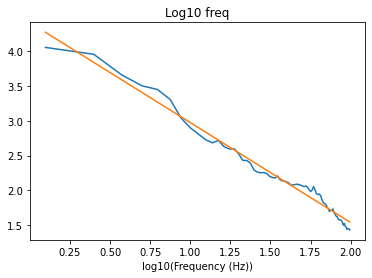

In [592]:
line = np.linspace(min(logFshape), max(logFshape), len(logFshape)).reshape(-1, 1)

plt.plot(log10Freq,avgPowDist)
plt.xlabel('log10(Frequency (Hz))')
plt.title('Log10 freq')
plt.plot(line, lr.predict(line))

In [586]:
# get equation of line, then antilog back to normal spectra for a "baseline"


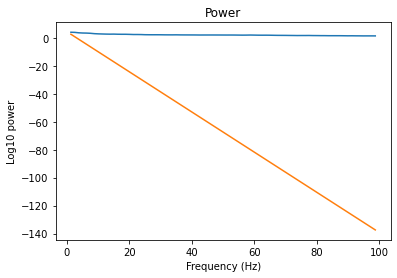

In [593]:
plt.plot(fSpec,avgPowDist)
plt.ylabel('Log10 power')
plt.xlabel('Frequency (Hz)')
plt.title('Power')
#line = np.linspace(min(fSpec), max(fSpec), len(fSpec)).reshape(-1, 1)
#lrLineAn = 10**(lr.predict(line))
#plt.plot(line, lrLineAn)